In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
# Basic preprocessing
def preprocess(df):
    df_new = df.copy()
    
    # Discard identifiers, style information, timestamps
    df_new = df_new[df_new.columns.difference(['image', 'style', 'reviewTime', 
                                               'reviewerID', 'asin', 'reviewerName', 'unixReviewTime'])]

    # Turn category into binary features
    for cat in df_new.category.unique():
        df_new[cat] = df_new['category'] == cat

    # Drop category column
    df_new.drop(columns=['category'], inplace=True)

    # NaN vote is 0 users found helpful
    df_new.vote.fillna(0, inplace=True)
    
    # Turn vote into binary feature
    df_new.vote = df_new.vote > 0
    # df_new.vote.clip(0, 10)
    # df_new.vote = df_new.vote / 10

    # NaN summary is empty summary
    df_new.summary.fillna('', inplace=True)

    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new

In [4]:
def apply_tfidf(df, review_vectorizer, summary_vectorizer):
    review_matrix = pd.DataFrame(data=review_vectorizer.transform(df.reviewText).toarray(), columns='R_' + review_vectorizer.get_feature_names_out())
    summary_matrix = pd.DataFrame(data=summary_vectorizer.transform(df.summary).toarray(), columns='S_' + summary_vectorizer.get_feature_names_out())
    df_new = pd.concat([df, review_matrix, summary_matrix], axis=1)
    df_new.drop(columns=['summary', 'reviewText'], inplace=True)
    return df_new

In [5]:
training_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Test.csv')

# Task 2

In [6]:
# Preprocessing of training data
proc_training_df = preprocess(training_df)

# Set X and y
X = proc_training_df.drop('overall', axis=1)
y = proc_training_df['overall']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [7]:
X

,verified,vote,automotive,CDs,grocery,cell_phones,sports,toys,R_00,R_000,...,S_zest,S_zest far,S_zest far inferior,S_zimmer,S_zipper,S_zippers,S_zoom,S_zz,S_zz greatest,S_zz greatest hits
0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.02]
relcols

Index(['verified', 'vote', 'R_10', 'R_20', 'R_30', 'R_30 days', 'R_50', 'R_99',
       'R_absolutely loves', 'R_actually',
       ...
       'S_worth', 'S_worth money', 'S_worthless', 'S_wouldn', 'S_yuck',
       'S_yuk', 'S_yum', 'S_yummy', 'S_zero', 'S_zero stars'],
      dtype='object', length=1099)

In [9]:
# We will go with these columns.
X = X[relcols]

In [10]:
# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Gaussian NB OVR

In [11]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = OneVsRestClassifier(estimator=GaussianNB())
params_GS = {'estimator__var_smoothing': np.logspace(-2, -9, num=15)}
gs_GS = GridSearchCV(estimator=gs_cls, param_grid=params_GS, cv=3, verbose=2, scoring='f1_macro')
gs_GS.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ......................estimator__var_smoothing=0.01; total time=   1.0s
[CV] END ......................estimator__var_smoothing=0.01; total time=   0.8s
[CV] END ......................estimator__var_smoothing=0.01; total time=   0.8s
[CV] END .....estimator__var_smoothing=0.0031622776601683794; total time=   0.9s
[CV] END .....estimator__var_smoothing=0.0031622776601683794; total time=   0.8s
[CV] END .....estimator__var_smoothing=0.0031622776601683794; total time=   0.8s
[CV] END .....................estimator__var_smoothing=0.001; total time=   0.9s
[CV] END .....................estimator__var_smoothing=0.001; total time=   0.8s
[CV] END .....................estimator__var_smoothing=0.001; total time=   0.8s
[CV] END ....estimator__var_smoothing=0.00031622776601683794; total time=   0.8s
[CV] END ....estimator__var_smoothing=0.00031622776601683794; total time=   0.7s
[CV] END ....estimator__var_smoothing=0.00031622

GridSearchCV(cv=3, estimator=OneVsRestClassifier(estimator=GaussianNB()),
             param_grid={'estimator__var_smoothing': array([1.00000000e-02, 3.16227766e-03, 1.00000000e-03, 3.16227766e-04,
       1.00000000e-04, 3.16227766e-05, 1.00000000e-05, 3.16227766e-06,
       1.00000000e-06, 3.16227766e-07, 1.00000000e-07, 3.16227766e-08,
       1.00000000e-08, 3.16227766e-09, 1.00000000e-09])},
             scoring='f1_macro', verbose=2)

In [12]:
gs_GS.best_params_

{'estimator__var_smoothing': 0.01}

In [13]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = OneVsRestClassifier(GaussianNB(**{k.split('__')[-1]: v 
                                                  for (k, v) in gs_GS.best_params_.items()}))
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")

Split 0:
  F1 score: 0.3720011795230375
  Accuracy: 0.3754710517300445
Split 1:
  F1 score: 0.3704371414838481
  Accuracy: 0.3713600548132922
Split 2:
  F1 score: 0.3823968237430503
  Accuracy: 0.38472079479273724
Split 3:
  F1 score: 0.3596746225544001
  Accuracy: 0.3672490578965399
Split 4:
  F1 score: 0.3745896057448504
  Accuracy: 0.3774199074867226
Average F1 score: 0.3718198746098373
Average accuracy: 0.3752441733438673


Text(33.0, 0.5, 'True label')

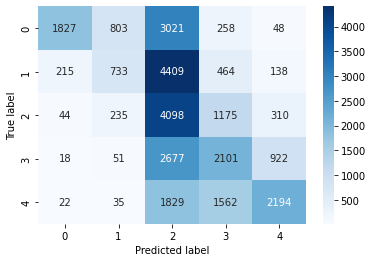

In [14]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

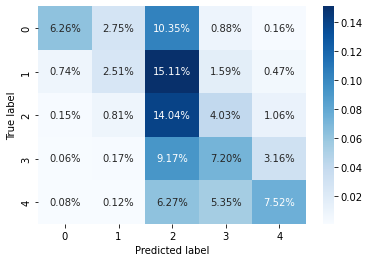

In [15]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [16]:
# Training on a new 80-20 split to compute AUC/ROC and draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_train_bin = pd.DataFrame(preprocessing.label_binarize(y_train, classes=range(1, 6)))
y_val_bin = pd.DataFrame(preprocessing.label_binarize(y_val, classes=range(1, 6)))
model = OneVsRestClassifier(GaussianNB(**{k.split('__')[-1]: v 
                                                  for (k, v) in gs_GS.best_params_.items()}))
model.fit(X_train, y_train_bin)
roc_auc_scores.append(roc_auc_score(y_val_bin, model.predict_proba(X_val)))
print(f"ROC/AUC score: {roc_auc_scores[-1]}")

ROC/AUC score: 0.7617871595563919


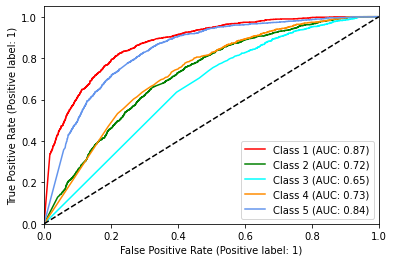

In [17]:
# ROC Curve
for i in range(5):
    model=OneVsRestClassifier(GaussianNB(**{k.split('__')[-1]: v 
                                                  for (k, v) in gs_GS.best_params_.items()}))
    model.fit(X_train, y_train_bin[i])
    RocCurveDisplay.from_predictions(y_val_bin[i], model.predict_proba(X_val)[:, 1], 
                                     color=["red", "green", "aqua", "darkorange", "cornflowerblue"][i],
                                     label=f"Class {i+1} (AUC: {roc_auc_score(y_val_bin[i], model.predict_proba(X_val)[:, 1]):.2f})", ax=plt.gca())
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

## Logistic Regression OVR

In [18]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = OneVsRestClassifier(estimator=LogisticRegression(max_iter=1500))
params_LR = {'estimator__C': np.logspace(-0.2, 0.7, num=10)}
gs_LR = GridSearchCV(estimator=gs_cls, param_grid=params_LR, cv=3, verbose=2, scoring='f1_macro')
gs_LR.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....................estimator__C=0.6309573444801932; total time=   7.7s
[CV] END ....................estimator__C=0.6309573444801932; total time=   8.1s
[CV] END ....................estimator__C=0.6309573444801932; total time=   8.2s
[CV] END ....................estimator__C=0.7943282347242815; total time=   8.2s
[CV] END ....................estimator__C=0.7943282347242815; total time=   8.7s
[CV] END ....................estimator__C=0.7943282347242815; total time=   8.9s
[CV] END ....................estimator__C=0.9999999999999999; total time=   9.1s
[CV] END ....................estimator__C=0.9999999999999999; total time=   9.1s
[CV] END ....................estimator__C=0.9999999999999999; total time=   9.9s
[CV] END .....................estimator__C=1.258925411794167; total time=  10.2s
[CV] END .....................estimator__C=1.258925411794167; total time=  10.0s
[CV] END .....................estimator__C=1.258

GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=LogisticRegression(max_iter=1500)),
             param_grid={'estimator__C': array([0.63095734, 0.79432823, 1.        , 1.25892541, 1.58489319,
       1.99526231, 2.51188643, 3.16227766, 3.98107171, 5.01187234])},
             scoring='f1_macro', verbose=2)

In [19]:
gs_LR.best_estimator_.get_params()

{'estimator__C': 3.9810717055349714,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 1500,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(C=3.9810717055349714, max_iter=1500),
 'n_jobs': None}

In [20]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = OneVsRestClassifier(LogisticRegression(**{k.split('__')[-1]: v 
                                                  for (k, v) in gs_LR.best_estimator_.get_params().items() 
                                                             if (k == 'estimator__C' or k == 'estimator__max_iter')}))
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")

Split 0:
  F1 score: 0.4693758592266281
  Accuracy: 0.47430626927029806
Split 1:
  F1 score: 0.46860826334829797
  Accuracy: 0.46933881466255567
Split 2:
  F1 score: 0.4838038832684532
  Accuracy: 0.4886947584789311
Split 3:
  F1 score: 0.47465016781947095
  Accuracy: 0.47584789311408016
Split 4:
  F1 score: 0.4716793483781041
  Accuracy: 0.4738735651875964
Average F1 score: 0.4227216895090141
Average accuracy: 0.42582821674327975


Text(33.0, 0.5, 'True label')

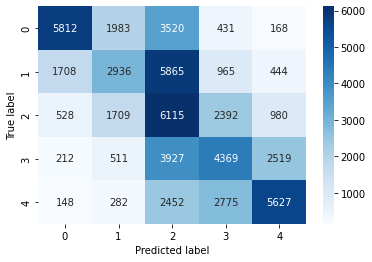

In [21]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

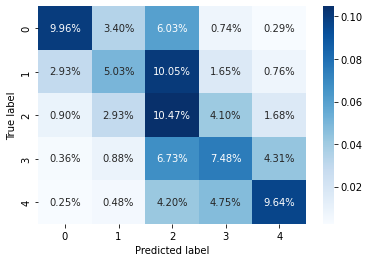

In [22]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [23]:
# Training on a new 80-20 split to compute AUC/ROC and draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_train_bin = pd.DataFrame(preprocessing.label_binarize(y_train, classes=range(1, 6)))
y_val_bin = pd.DataFrame(preprocessing.label_binarize(y_val, classes=range(1, 6)))
model = OneVsRestClassifier(LogisticRegression(**{k.split('__')[-1]: v 
                                                  for (k, v) in gs_LR.best_estimator_.get_params().items() 
                                                             if (k == 'estimator__C' or k == 'estimator__max_iter')}))
model.fit(X_train, y_train_bin)
roc_auc_scores.append(roc_auc_score(y_val_bin, model.predict_proba(X_val)))
print(f"ROC/AUC score: {roc_auc_scores[-1]}")

ROC/AUC score: 0.7876019780638325


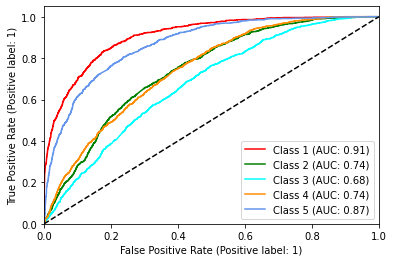

In [24]:
# ROC Curve
for i in range(5):
    model = OneVsRestClassifier(LogisticRegression(**{k.split('__')[-1]: v 
                                                    for (k, v) in gs_LR.best_estimator_.get_params().items() 
                                                               if (k == 'estimator__C' or k == 'estimator__max_iter')}))
    model.fit(X_train, y_train_bin[i])
    RocCurveDisplay.from_predictions(y_val_bin[i], model.predict_proba(X_val)[:, 1], 
                                     color=["red", "green", "aqua", "darkorange", "cornflowerblue"][i],
                                     label=f"Class {i+1} (AUC: {roc_auc_score(y_val_bin[i], model.predict_proba(X_val)[:, 1]):.2f})", ax=plt.gca())
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

## Decision Tree Classifier OVR

In [25]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = OneVsRestClassifier(estimator=DecisionTreeClassifier())
params_DT = {'estimator__criterion': ['entropy','gini'], 'estimator__max_depth': np.arange(40, 101, 15)}
gs_DT = GridSearchCV(estimator=gs_cls, param_grid=params_DT, cv=3, verbose=2, scoring='f1_macro')
gs_DT.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END estimator__criterion=entropy, estimator__max_depth=40; total time=   6.6s
[CV] END estimator__criterion=entropy, estimator__max_depth=40; total time=   6.5s
[CV] END estimator__criterion=entropy, estimator__max_depth=40; total time=   6.5s
[CV] END estimator__criterion=entropy, estimator__max_depth=55; total time=   7.5s
[CV] END estimator__criterion=entropy, estimator__max_depth=55; total time=   7.9s
[CV] END estimator__criterion=entropy, estimator__max_depth=55; total time=   7.8s
[CV] END estimator__criterion=entropy, estimator__max_depth=70; total time=   8.5s
[CV] END estimator__criterion=entropy, estimator__max_depth=70; total time=   8.9s
[CV] END estimator__criterion=entropy, estimator__max_depth=70; total time=   8.8s
[CV] END estimator__criterion=entropy, estimator__max_depth=85; total time=   9.2s
[CV] END estimator__criterion=entropy, estimator__max_depth=85; total time=   9.6s
[CV] END estimator__criter

GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=DecisionTreeClassifier()),
             param_grid={'estimator__criterion': ['entropy', 'gini'],
                         'estimator__max_depth': array([ 40,  55,  70,  85, 100])},
             scoring='f1_macro', verbose=2)

In [26]:
gs_DT.best_params_

{'estimator__criterion': 'entropy', 'estimator__max_depth': 40}

In [27]:
from warnings import simplefilter
simplefilter(action='ignore', category=RuntimeWarning)

In [28]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = OneVsRestClassifier(DecisionTreeClassifier(**{k.split('__')[-1]: v 
                                                          for (k, v) in gs_DT.best_params_.items()}))
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")

Split 0:
  F1 score: 0.36951696958338054
  Accuracy: 0.36639260020554987
Split 1:
  F1 score: 0.38067561863270344
  Accuracy: 0.37375813634806443
Split 2:
  F1 score: 0.3574074838926535
  Accuracy: 0.355258650222679
Split 3:
  F1 score: 0.37349985276786246
  Accuracy: 0.36913326481671804
Split 4:
  F1 score: 0.3604289834004305
  Accuracy: 0.35720404317286275
Average F1 score: 0.4045830535578114
Average accuracy: 0.4053352574799115


Text(33.0, 0.5, 'True label')

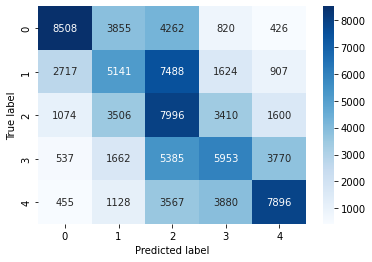

In [29]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

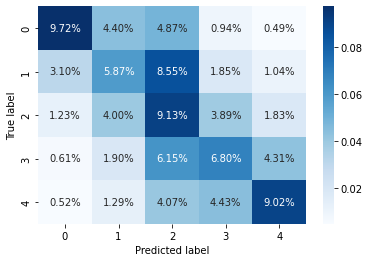

In [30]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [31]:
# Training on a new 80-20 split to compute AUC/ROC and draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_train_bin = pd.DataFrame(preprocessing.label_binarize(y_train, classes=range(1, 6)))
y_val_bin = pd.DataFrame(preprocessing.label_binarize(y_val, classes=range(1, 6)))
model = OneVsRestClassifier(DecisionTreeClassifier(**{k.split('__')[-1]: v 
                                                          for (k, v) in gs_DT.best_params_.items()}))
model.fit(X_train, y_train_bin)
roc_auc_scores.append(roc_auc_score(y_val_bin, model.predict_proba(X_val)))
print(f"ROC/AUC score: {roc_auc_scores[-1]}")

ROC/AUC score: 0.6476956751229161


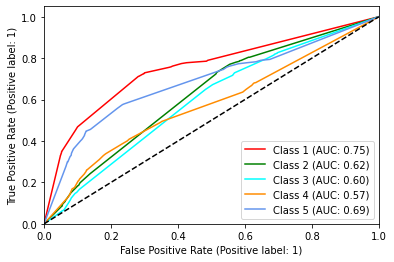

In [32]:
# ROC Curve
for i in range(5):
    model=OneVsRestClassifier(DecisionTreeClassifier(**{k.split('__')[-1]: v 
                                                          for (k, v) in gs_DT.best_params_.items()}))
    model.fit(X_train, y_train_bin[i])
    RocCurveDisplay.from_predictions(y_val_bin[i], model.predict_proba(X_val)[:, 1], 
                                     color=["red", "green", "aqua", "darkorange", "cornflowerblue"][i],
                                     label=f"Class {i+1} (AUC: {roc_auc_score(y_val_bin[i], model.predict_proba(X_val)[:, 1]):.2f})", ax=plt.gca())
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [35]:
model_fin = OneVsRestClassifier(estimator=LogisticRegression(C=3.9810717055349714,
                                                             max_iter=1500))
model_fin.fit(X, y)

OneVsRestClassifier(estimator=LogisticRegression(C=3.9810717055349714,
                                                 max_iter=1500))

In [36]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [37]:
proc_test_df['predicted'] = model_fin.predict(proc_test_df)
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task2.csv', index=False)